In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from scipy.ndimage import shift
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
from scipy.spatial import cKDTree
import pandas as pd
from scipy.signal import fftconvolve
from multiprocessing.dummy import Pool
from tqdm import tqdm

In [3]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

In [4]:
def align_fluxes_by_reference(dfs, max_dist=2.0):
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    x_ref = ref_df['x'].values
    y_ref = ref_df['y'].values
    ref_points = np.column_stack((x_ref, y_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        x = df['x'].values
        y = df['y'].values
        points = np.column_stack((x, y))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix


In [ ]:
# Set location data
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

In [6]:
# Set aperture size
aperture_size = 4

In [ ]:

catalog = Table.read(f'{location}/53.0_-28.0/u.cat', format='ascii')
print(catalog.colnames)
print(np.mean(catalog['FLUX_RADIUS']))

['X_IMAGE', 'Y_IMAGE', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_RADIUS', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'NUMBER', 'FLAGS']
3.665458027709861


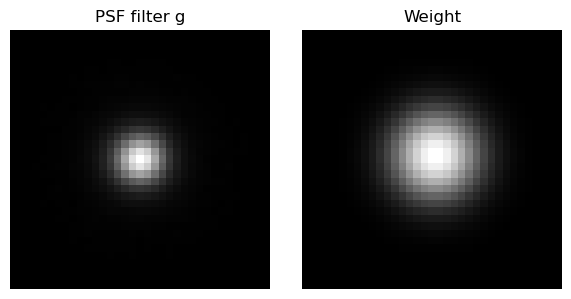

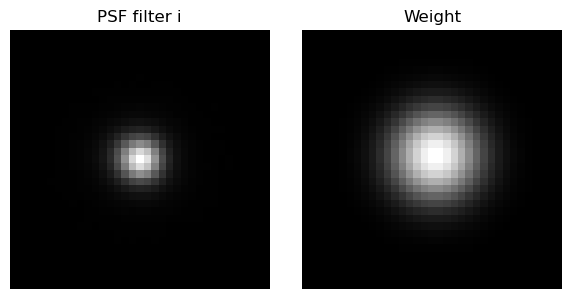

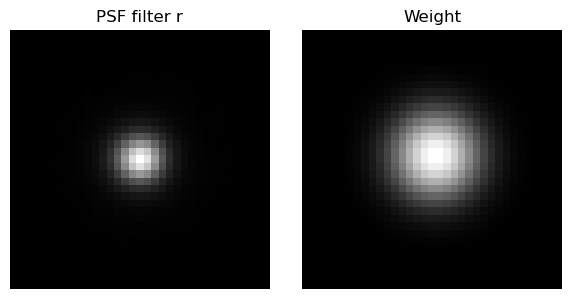

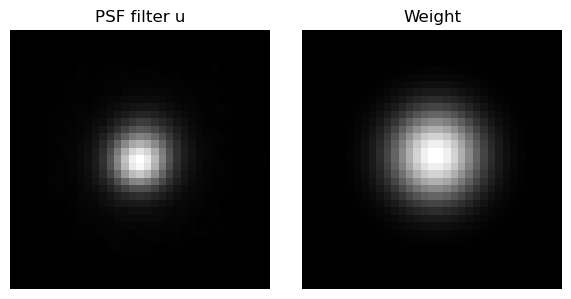

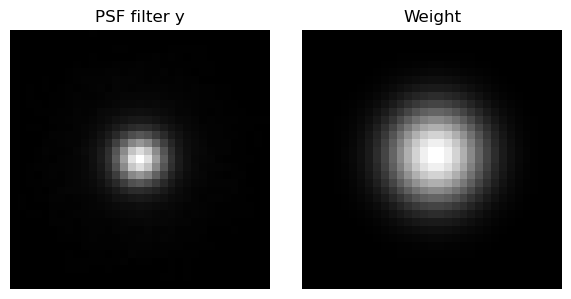

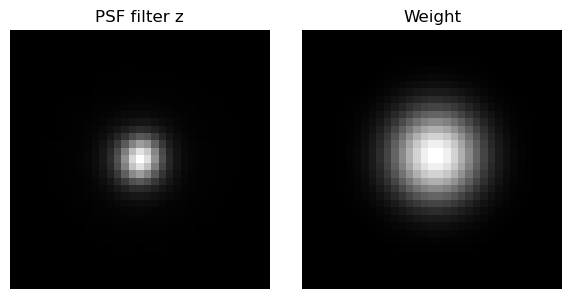

In [8]:
filters = ['g', 'i', 'r', 'u', 'y', 'z']
for filter in filters:
    # Open the PSF file
    with fits.open(f'{location}/53.0_-28.0/{filter}_53.00_-28.00.psf.fits') as hdul:
        psf = hdul[0].data

    # Calculate the weight function for set aperture size
    weight = gaussian_weight(psf.shape[0], psf.shape[1], psf.shape[0]/2, psf.shape[1]/2, aperture_size, aperture_size)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Plot the psf
    axes[0].imshow(psf)
    axes[0].set_title(f'PSF filter {filter}')

    # Plot the weight
    axes[1].imshow(weight)
    axes[1].set_title('Weight')

    plt.tight_layout()
    plt.show()


In [9]:
field = '53.0_-28.0'
file = '53.00_-28.00'

In [10]:
# Filters to be used
filters = ['u', 'g', 'r', 'i', 'y', 'z']
sigma = np.zeros_like(filters, dtype=float)
for i, filter in tqdm(enumerate(filters)):
    # Open the catalog
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='ascii')
    
    # Open the image
    hdul = fits.open(f'{location}/{field}/{filter}_{file}.fits')
    image_data = hdul[1].data
    hdul.close()

    # Open the PSF
    hdul = fits.open(f'{location}/{field}/{filter}_{file}.psf.fits')
    psf = hdul[0].data
    hdul.close()

    # Set the weight function for set aperture size
    weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, aperture_size, aperture_size)

    centers = [[xc, yc] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]

    flux, sigma[i] = calculate_gaap_flux(image_data, psf, weight, centers)
    
    # Store the data in a dataframe
    data = {'x': np.array(catalog['X_IMAGE']), 'y': np.array(catalog['Y_IMAGE'])}
    data['flux'] = flux

    if filter == 'u':
        u_df = pd.DataFrame(data)
    elif filter == 'g':
        g_df = pd.DataFrame(data)
    elif filter == 'r':
        r_df = pd.DataFrame(data)
    elif filter == 'i':
        i_df = pd.DataFrame(data)
    elif filter == 'y':
        y_df = pd.DataFrame(data)
    elif filter == 'z':
        z_df = pd.DataFrame(data)
    

0it [00:00, ?it/s]

6it [00:46,  7.69s/it]


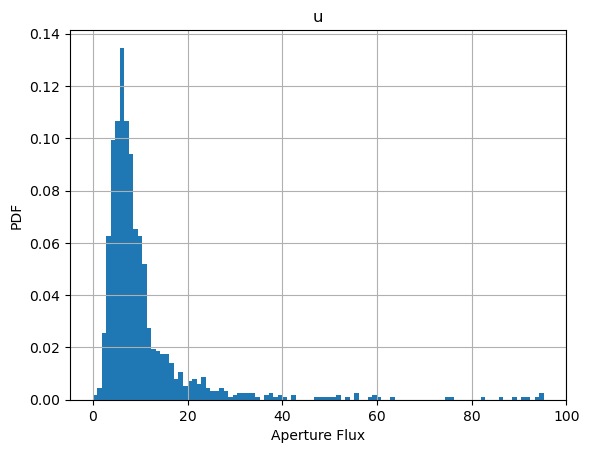

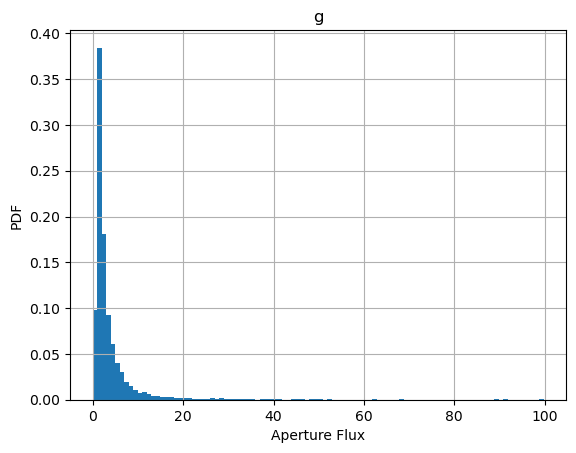

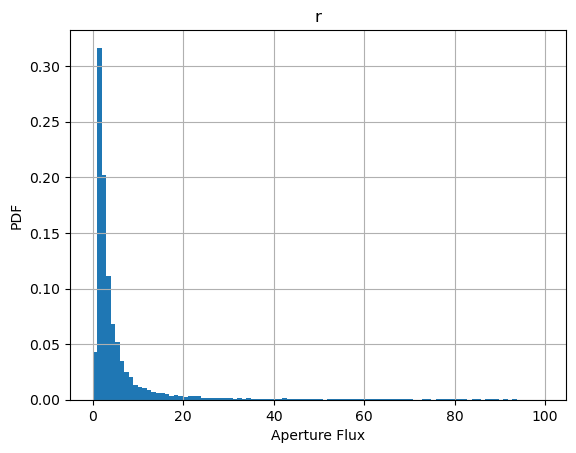

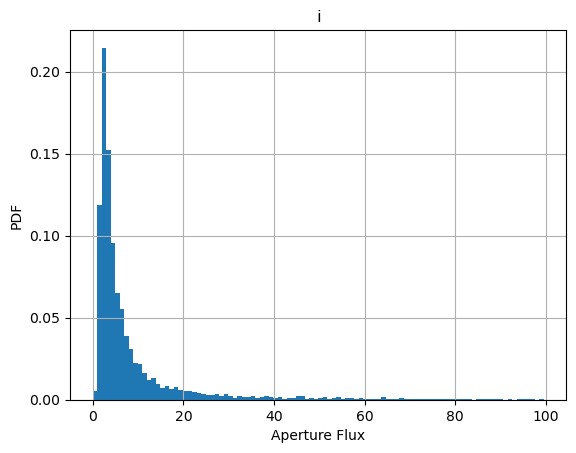

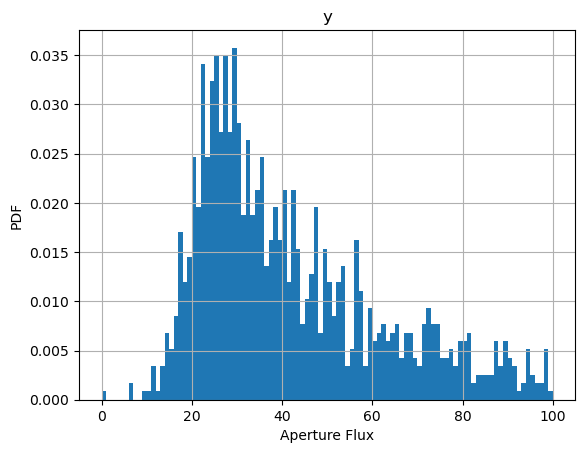

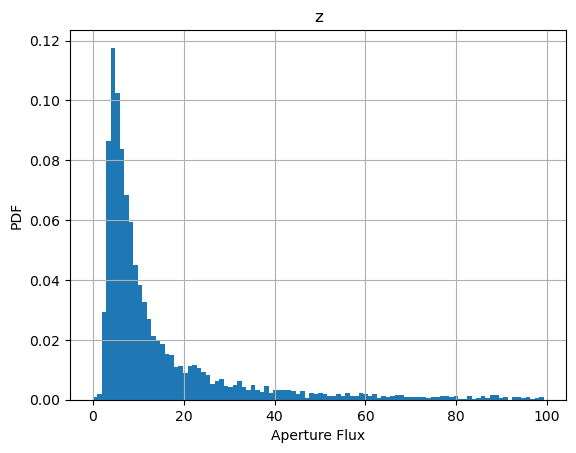

In [11]:
dfs = {
    'u': u_df,
    'g': g_df,
    'r': r_df,
    'i': i_df,
    'y': y_df,
    'z': z_df
}

for key, df in dfs.items():
    with plt.rc_context(
        {
            "xtick.bottom": True,
            "xtick.labelbottom": True,
            "ytick.left": True,
            "ytick.labelleft": True,
            "axes.edgecolor": "black",
            "axes.grid": True,
        }
    ):
        # Plot the aperture flux distributions
        plt.hist(df["flux"][df["flux"] < 100], bins=100, density=True)
        plt.xlabel("Aperture Flux")
        plt.ylabel("PDF")
        plt.title(key)
        plt.show()

In [ ]:
dfs = {
    'g': g_df,
    'r': r_df,
    'i': i_df
}

In [13]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['g', 'r', 'i']
Flux matrix shape: (8357, 3)


/var/tmp/deklerk/ipykernel_294516/3722389872.py:15: RuntimeWarning: divide by zero encountered in divide
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:16: RuntimeWarning: divide by zero encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:16: RuntimeWarning: invalid value encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:16: RuntimeWarning: divide by zero encountered in log10
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
/var/tmp/deklerk/ipykernel_294516/3722389872

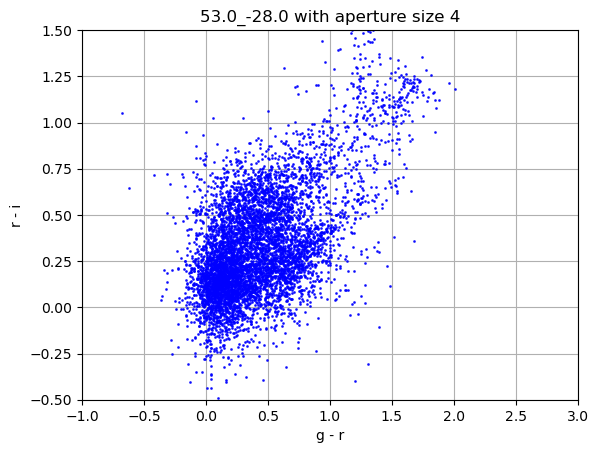

In [16]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)*0

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

/var/tmp/deklerk/ipykernel_294516/3346539704.py:15: RuntimeWarning: divide by zero encountered in divide
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:16: RuntimeWarning: divide by zero encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:16: RuntimeWarning: invalid value encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:16: RuntimeWarning: divide by zero encountered in log10
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
/var/tmp/deklerk/ipykernel_294516/3346539704.p

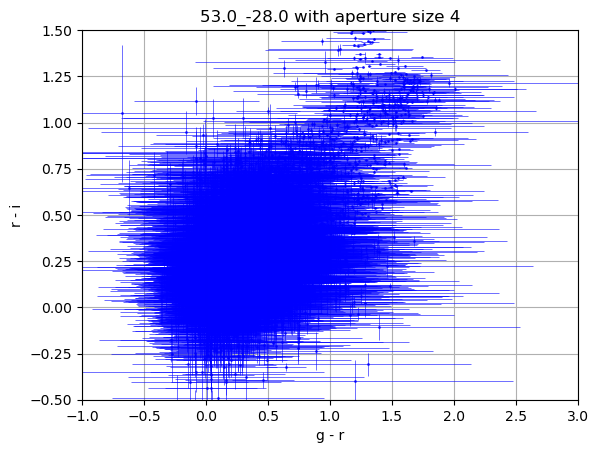

In [15]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

In [ ]:
dfs = {
    'r': r_df,
    'i': i_df,
    'z': z_df
}

In [19]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['r', 'i', 'z']
Flux matrix shape: (5509, 3)


/var/tmp/deklerk/ipykernel_294516/3722389872.py:15: RuntimeWarning: invalid value encountered in divide
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:15: RuntimeWarning: divide by zero encountered in log10
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:16: RuntimeWarning: divide by zero encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:16: RuntimeWarning: invalid value encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
/var/tmp/deklerk/ipykernel_294516/3722389872.

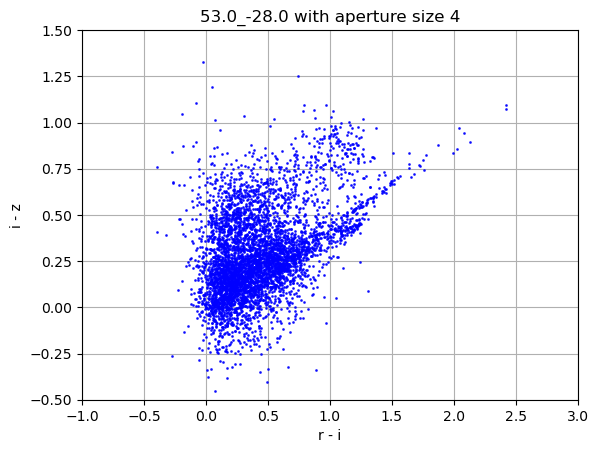

In [20]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)*0

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

/var/tmp/deklerk/ipykernel_294516/3346539704.py:15: RuntimeWarning: invalid value encountered in divide
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:15: RuntimeWarning: divide by zero encountered in log10
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:16: RuntimeWarning: divide by zero encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:16: RuntimeWarning: invalid value encountered in divide
  y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
/var/tmp/deklerk/ipykernel_294516/3346539704.py

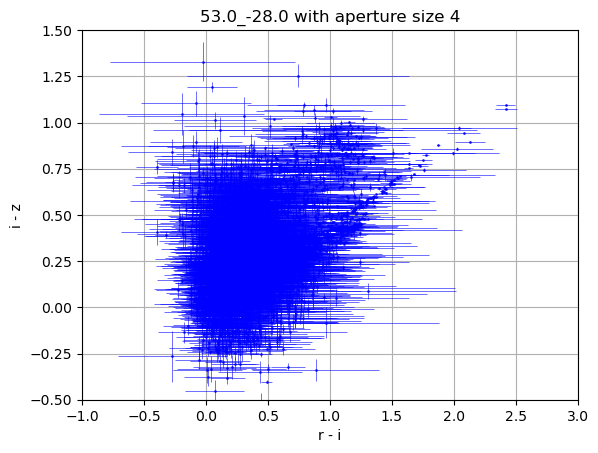

In [21]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

In [22]:
dfs = {
    'u': u_df,
    'g': g_df,
    'r': r_df
}

In [23]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['u', 'g', 'r']
Flux matrix shape: (1227, 3)


/var/tmp/deklerk/ipykernel_294516/3722389872.py:15: RuntimeWarning: divide by zero encountered in log10
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3722389872.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
/var/tmp/deklerk/ipykernel_294516/3722389872.py:18: RuntimeWarning: invalid value encountered in multiply
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0


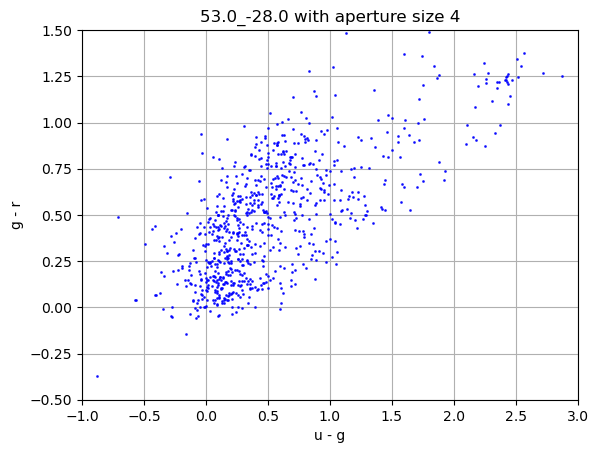

In [24]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)*0
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)*0

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

/var/tmp/deklerk/ipykernel_294516/3346539704.py:15: RuntimeWarning: divide by zero encountered in log10
  x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
/var/tmp/deklerk/ipykernel_294516/3346539704.py:18: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)


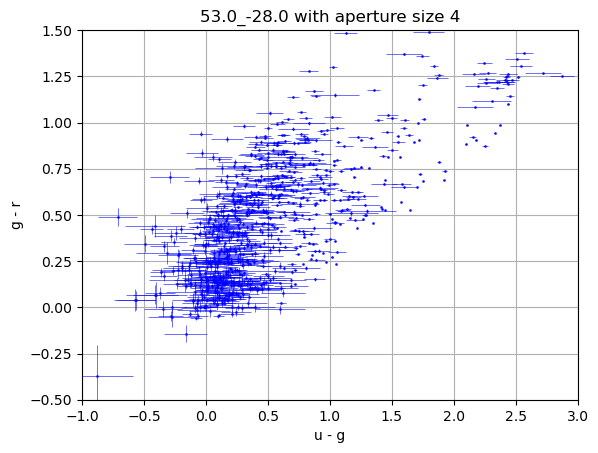

In [25]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)

    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.xlim(-1, 3)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

179


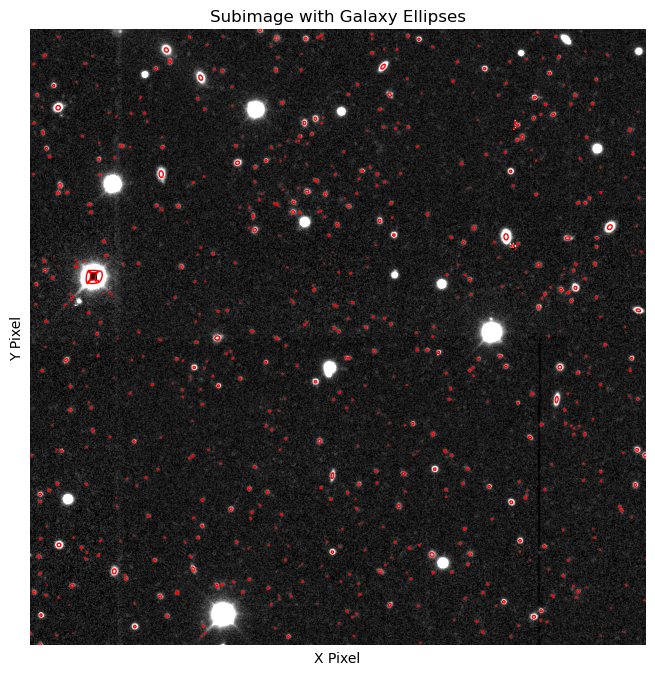

In [66]:
location = '/net/vdesk/data2/deklerk/GAAP_data/'

x_start, x_end = 1000, 4000
y_start, y_end = 1000, 4000


catalog = Table.read(f'{location}/DES-R.cat', format='fits', hdu=2)
with fits.open(f'{location}/DES-R_TILE102044185.fits') as hdul:
    image_data = hdul[0].data[y_start:y_end, x_start:x_end].copy()
x = catalog['X_IMAGE']
y = catalog['Y_IMAGE']
a = catalog['A_IMAGE']
b = catalog['B_IMAGE']
theta = catalog['THETA_IMAGE']
star = catalog['CLASS_STAR']
print(len(star[star > 0.8]))
mask = (x >= x_start) & (x < x_end) & (y >= y_start) & (y < y_end) & (star < 0.1)
x_sub = x[mask] - x_start
y_sub = y[mask] - y_start
a_sub = a[mask]
b_sub = b[mask]
theta_sub = theta[mask]

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image_data, origin='lower', cmap='gray',
          vmin=np.percentile(image_data,5), vmax=np.percentile(image_data,99))

for xi, yi, ai, bi, ti in zip(x_sub, y_sub, a_sub, b_sub, theta_sub):
    ell = Ellipse((xi, yi), width=2*ai, height=2*bi, angle=ti,
                  edgecolor='red', facecolor='none', lw=1)
    ax.add_patch(ell)

ax.set_xlabel('X Pixel')
ax.set_ylabel('Y Pixel')
ax.set_title('Subimage with Galaxy Ellipses')
plt.show()

In [28]:
from matplotlib.patches import Ellipse

['X_IMAGE', 'Y_IMAGE', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_RADIUS', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'NUMBER', 'FLAGS']


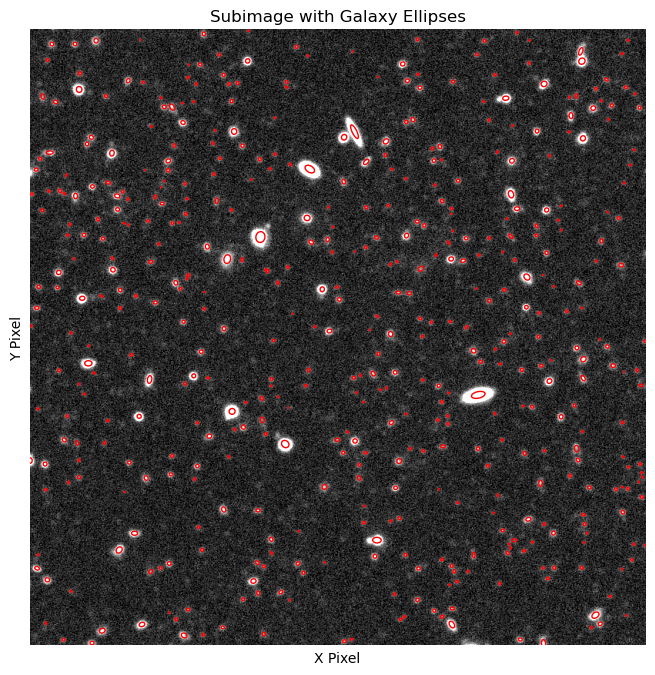

In [59]:
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

x_start, x_end = 1600, 2400
y_start, y_end = 1600, 2400


catalog = Table.read(f'{location}/53.0_-28.0/g.cat', format='ascii')
print(catalog.colnames)
with fits.open(f'{location}/53.0_-28.0/g_53.00_-28.00.fits') as hdul:
    image_data = hdul[1].data[y_start:y_end, x_start:x_end].copy()
x = catalog['X_IMAGE']
y = catalog['Y_IMAGE']
a = catalog['A_IMAGE']
b = catalog['B_IMAGE']
theta = catalog['THETA_IMAGE']

# -----------------------------
# Filter points inside subimage
# -----------------------------
mask = (x >= x_start) & (x < x_end) & (y >= y_start) & (y < y_end)
x_sub = x[mask] - x_start
y_sub = y[mask] - y_start
a_sub = a[mask]
b_sub = b[mask]
theta_sub = theta[mask]


# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image_data, origin='lower', cmap='gray',
          vmin=np.percentile(image_data,5), vmax=np.percentile(image_data,99))

# Draw ellipses for each galaxy
for xi, yi, ai, bi, ti in zip(x_sub, y_sub, a_sub, b_sub, theta_sub):
    ell = Ellipse((xi, yi), width=2*ai, height=2*bi, angle=ti,
                  edgecolor='red', facecolor='none', lw=1)
    ax.add_patch(ell)

ax.set_xlabel('X Pixel')
ax.set_ylabel('Y Pixel')
ax.set_title('Subimage with Galaxy Ellipses')
plt.show()

In [58]:
location = '/net/vdesk/data2/deklerk/GAAP_data/'
catalog = Table.read(f'{location}/DES-R.cat', format='fits', hdu=2)
print(catalog['CLASS_STAR'])
hdul = fits.open(f'{location}/DES-R.cat')
hdul.info()

CLASS_STAR
----------
     0.020
     0.000
     0.000
     0.796
     0.000
     0.000
     0.077
     0.000
     0.073
     0.000
       ...
     0.000
     0.831
     0.000
     0.000
     0.000
     0.000
     0.000
     0.000
     0.000
     0.000
     0.000
Length = 30325 rows
Filename: /net/vdesk/data2/deklerk/GAAP_data//DES-R.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [7760A]   
  2  LDAC_OBJECTS    1 BinTableHDU     50   30325R x 11C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1I, 1E]   
